In [1]:
#https://github.com/pomber/covid19
print('Initializing São Paulo\'s analysis!')
import numpy as np
import pandas as pd
import folium, html, json
import matplotlib.pyplot as plt
import datetime

Initializing São Paulo's analysis!


In [2]:
# df = pd.read_csv('../data/saoPaulo_corona19_data.csv')
df = pd.read_csv('../data/brazil_corona19_data.csv')
df['date'] = df['date'].astype('datetime64[ns]')
df['codmun'] = df['codmun'].astype('int')

today = df.date.max().date()
tomorrow = today + datetime.timedelta(days=1)
yesterday = today - datetime.timedelta(days=1)
qtdeMonitored = 5

df = df[(df['state']=='SP') & (df['codmun']!=0) & (df['city']!='-')]

df.tail()


,region,state,city,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,date,semanaEpi,population,...,avg7_cases,avg7_deaths,avg7_recoveries,perc_death,avg7_perc_death,avg7_case_day_thousand,avg7_death_day_thousand,avg7_recovery_day_thousand,perc_recovery,active_cases
60585,Sudeste,SP,Estiva Gerbi,35,355730,35141.0,Baixa Mogiana,2020-05-10,20,11304.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
60586,Sudeste,SP,Estiva Gerbi,35,355730,35141.0,Baixa Mogiana,2020-05-11,20,11304.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
60587,Sudeste,SP,Estiva Gerbi,35,355730,35141.0,Baixa Mogiana,2020-05-12,20,11304.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
60588,Sudeste,SP,Estiva Gerbi,35,355730,35141.0,Baixa Mogiana,2020-05-13,20,11304.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
60589,Sudeste,SP,Estiva Gerbi,35,355730,35141.0,Baixa Mogiana,2020-05-14,20,11304.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [3]:
city_geo = json.load(open('../data/saoPaulo-cidades.json'))
df_mapa = df[df['date']==str(today)].copy()
cities = df_mapa.city.unique()

for cidade in city_geo['features']:
    latLon =  cidade['properties']['centroide']
    codarea = int(cidade['properties']['codarea'])

    #codmun não tem o último número do codarea, tenho que tirar para igualar
    df_mapa.loc[df_mapa['codmun']==(int(codarea/10)), 'codmun'] = codarea
    df_mapa.loc[df_mapa['codmun']==codarea,'lat'] = latLon[1]
    df_mapa.loc[df_mapa['codmun']==codarea,'long'] = latLon[0]

df_mapa.tail()

,region,state,city,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,date,semanaEpi,population,...,avg7_recoveries,perc_death,avg7_perc_death,avg7_case_day_thousand,avg7_death_day_thousand,avg7_recovery_day_thousand,perc_recovery,active_cases,lat,long
60441,Sudeste,SP,Vista Alegre do Alto,35,3556909,35052.0,Sul - Barretos,2020-05-14,20,8810.0,...,0.0,0.00,0.00,0.000,0.000,0.0,0.0,1.0,-21.176638,-48.650313
60486,Sudeste,SP,Votorantim,35,3557006,35163.0,Sorocaba,2020-05-14,20,122480.0,...,0.0,7.50,8.89,0.019,0.001,0.0,0.0,37.0,-23.580280,-47.405184
60531,Sudeste,SP,Votuporanga,35,3557105,35157.0,Votuporanga,2020-05-14,20,94547.0,...,0.0,3.85,2.24,0.006,0.002,0.0,0.0,25.0,-20.458517,-49.990003
60555,Sudeste,SP,Chavantes,35,3557204,35094.0,Ourinhos,2020-05-14,20,12418.0,...,0.0,0.00,0.00,0.000,0.000,0.0,0.0,1.0,-23.047135,-49.727685
60589,Sudeste,SP,Estiva Gerbi,35,3557303,35141.0,Baixa Mogiana,2020-05-14,20,11304.0,...,0.0,0.00,0.00,0.000,0.000,0.0,0.0,1.0,-22.236698,-46.943568


In [4]:
state_geo = json.load(open('../data/saoPaulo-cidades.json'))
m = folium.Map(location=[-22.60, -48.44], zoom_start=7)
df_mapa.codmun = df_mapa.codmun.astype('str')

folium.Choropleth(
    geo_data=state_geo,
    name='Mortes por mil habitantes',
    data=df_mapa,
    columns=['codmun','deaths_thousand'],
    key_on='feature.properties.codarea',
    highlight=True,
    fill_color='YlOrRd',#'YlGn',
#     ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
    fill_opacity=0.7,
    line_opacity=0.3,
    nan_fill_color = 'white',
    nan_fill_opacity = 0.1,
    legend_name= 'mortes por mil habitades'
).add_to(m)

for city in cities:
    dados = df_mapa[(df_mapa['city']==city)]# & (df['date']==str(today))]
    if dados.empty:
        print('cidade vazia:', city)
        continue
    detalhes = '<center><b>'+dados.city.values[0] +'</b></center>\n'
    detalhes += 'casos: ' + str(dados.cases.sum()) + ', mortes: ' + str(dados.deaths.sum())
    detalhes += ', mortes/1k hab.: ' + str(dados.deaths_thousand.values[0].round(3))
    
    folium.CircleMarker(
        location=[dados.lat,dados.long],
        radius=2,
#         popup=detalhes,
        color='#727b7d',
        fill=True,
        fill_color='#ffff',
        tooltip=detalhes,
        icon=folium.Icon(color='blue',
             icon_color='black',
             icon='info-sign',
             prefix='es')
    ).add_to(m)

folium.LayerControl().add_to(m)

m.save('../analysis/maps/saoPauloMapDeaths.html')
m

In [5]:
m = folium.Map(location=[-22.60, -48.44], zoom_start=7)
df_mapa.codmun = df_mapa.codmun.astype('str')

folium.Choropleth(
    geo_data=state_geo,
    name='Contaminações por 100 mil habitantes',
    data=df_mapa,
    columns=['codmun', 'cases_thousand'],
    key_on='feature.properties.codarea',
    fill_color='PuRd',#'YlGn',
    #     ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
    fill_opacity=0.7,
    line_opacity=0.3,
    nan_fill_color = 'white',
    nan_fill_opacity = 0.1,
    legend_name='casos por 100mil habitantes'
).add_to(m)

for city in cities:
    dados = df_mapa[(df_mapa['city']==city)]# & (df['date']==str(today))]
    if dados.empty:
        print('cidade vazia:', city)
        continue
    detalhes = '<center><b>'+dados.city.values[0] +'</b></center>\n'
    detalhes += 'casos: ' + str(dados.cases.sum()) + ', mortes: ' + str(dados.deaths.sum())
    detalhes += ', casos/100k hab.: ' + str(dados.cases_thousand.values[0].round(3))
    
    folium.CircleMarker(
        location=[dados.lat,dados.long],
        radius=2,
#         popup=detalhes,
        color='#727b7d',
        fill=True,
        fill_color='#ffff',
        tooltip=detalhes,
        icon=folium.Icon(color='blue',
             icon_color='black',
             icon='info-sign',
             prefix='es')
    ).add_to(m)

folium.LayerControl().add_to(m)

m.save('../analysis/maps/saoPauloMapCases.html')
m

In [6]:
# #https://www.mankier.com/1/wkhtmltoimage#--width
# import imgkit
# print('Gerando imagens dos mapas de São Paulo')
# options = {
#     'format': 'png',
# #     'crop-h': '3',
# #     'crop-w': '3',
# #     'crop-x': '3',
# #     'crop-y': '3',
#     'width':'300',
#     'encoding': "UTF-8",
#     'custom-header' : [
#         ('Accept-Encoding', 'gzip')
#     ],
# }
# imgkit.from_file('../analysis/maps/saoPauloMapDeathsContainer.html', '../analysis/maps/saoPauloMapDeaths.png', options=options)
# imgkit.from_file('../analysis/maps/saoPauloMapCasesContainer.html', '../analysis/maps/saoPauloMapCases.png', options=options)

----------------------------
### São Paulo - Analysis and monitoring

In [7]:
#week variation
lastWeek = today - datetime.timedelta(days=7)
saoPauloCities = 645

#contaminated cities
lastWeekCities = len(df.loc[df['date']==str(lastWeek), 'city'].unique())
lastWeekPercCities = int(lastWeekCities / saoPauloCities * 100)
todayCities = len(df.city.unique())
todayPercCities = int((todayCities / saoPauloCities * 100))
varCities = int((todayCities / lastWeekCities - 1) *100)
diffCities = todayCities - lastWeekCities

# cases and deaths
lastWeekCases = df.loc[df['date']==str(lastWeek), 'cases'].sum()
lastWeekDeaths = df.loc[df['date']==str(lastWeek), 'deaths'].sum()
todayCases = df.loc[df['date']==str(today), 'cases'].sum()
todayDeaths = df.loc[df['date']==str(today), 'deaths'].sum()
varCases = int((todayCases / lastWeekCases - 1) *100)
varDeaths = int((todayDeaths / lastWeekDeaths - 1) *100)
diffCases = todayCases - lastWeekCases
diffDeaths = todayDeaths - lastWeekDeaths

#### Top deadliest cities  + Santa Gertrudes + Lucelia + Rio Claro + outras

In [8]:
cols = ['city', 'date', 'day', 'population','case_day', 'cases', 'death_day', 'deaths', 'cases_thousand', 'deaths_thousand', 'perc_death']
addedCities = ['Santa Gertrudes', 'Rio Claro','Cordeirópolis', 'Limeira','Lucélia','Adamantina']

df_top_deaths = df[df['date']==str(today)].sort_values('deaths_thousand', ascending = False)

df_top_deaths.reset_index(0, inplace=True)
df_top_deaths.index = df_top_deaths.index + 1
df_top_deaths = df_top_deaths[cols].head(qtdeMonitored).append(df_top_deaths[df_top_deaths['city'].isin(addedCities)][cols])

df_top_deaths

,city,date,day,population,case_day,cases,death_day,deaths,cases_thousand,deaths_thousand,perc_death
1,Uru,2020-05-14,9,1165.0,0,3,0,1,2.575,0.858,33.33
2,São João das Duas Pontes,2020-05-14,2,2568.0,1,2,0,1,0.779,0.389,50.00
3,Pedrinhas Paulista,2020-05-14,14,3093.0,0,3,0,1,0.970,0.323,33.33
4,Arandu,2020-05-14,28,6357.0,0,10,0,2,1.573,0.315,20.00
5,Barueri,2020-05-14,48,274182.0,28,586,7,73,2.137,0.266,12.46
21,Lucélia,2020-05-14,22,21747.0,2,18,0,3,0.828,0.138,16.67
99,Rio Claro,2020-05-14,47,206424.0,1,25,0,9,0.121,0.044,36.00
196,Limeira,2020-05-14,44,306114.0,4,69,0,1,0.225,0.003,1.45
250,Santa Gertrudes,2020-05-14,29,26898.0,0,1,0,0,0.037,0.000,0.00
287,Adamantina,2020-05-14,33,35068.0,3,23,0,0,0.656,0.000,0.00


#### Top most transmissible countries + Santa Gertrude + Lucélia + Adamantina + Rio Claro + Cordeirópolis + Limeira - São Paulo

In [9]:
df_top_cases = df[(df['date']==str(today)) & (df['population']>10000)].sort_values('cases_thousand', ascending = False)

df_top_cases.reset_index(0, inplace=True)
df_top_cases.index = df_top_cases.index + 1
df_top_cases = df_top_cases[cols].head(qtdeMonitored+1).append(df_top_cases[df_top_cases['city'].isin(addedCities)][cols])

df_top_cases

,city,date,day,population,case_day,cases,death_day,deaths,cases_thousand,deaths_thousand,perc_death
1,Pariquera-Açu,2020-05-14,41,19648.0,3,58,0,1,2.952,0.051,1.72
2,Santos,2020-05-14,48,433311.0,78,1147,4,73,2.647,0.168,6.36
3,São Paulo,2020-05-14,48,12252023.0,1471,31873,100,2596,2.601,0.212,8.14
4,São Sebastião,2020-05-14,48,88980.0,47,210,0,2,2.360,0.022,0.95
5,Barueri,2020-05-14,48,274182.0,28,586,7,73,2.137,0.266,12.46
6,Osasco,2020-05-14,48,698418.0,76,1466,15,180,2.099,0.258,12.28
29,Cordeirópolis,2020-05-14,21,24528.0,1,25,0,0,1.019,0.000,0.00
55,Lucélia,2020-05-14,22,21747.0,2,18,0,3,0.828,0.138,16.67
72,Adamantina,2020-05-14,33,35068.0,3,23,0,0,0.656,0.000,0.00
193,Limeira,2020-05-14,44,306114.0,4,69,0,1,0.225,0.003,1.45


#### Cities of São Paulo to be analised

#### Cases and deaths 

In [10]:
#inform the countries you want to analise
monitoredCities = df_top_cases['city'].head(qtdeMonitored+1).to_numpy()
# monitoredCities = df[(df['date']==str(today)) & (df['population']>10000)].sort_values('cases_thousand', ascending = False).head(qtdeMonitored+1).city.to_numpy()
# monitoredCities = np.delete(monitoredCities,np.where([monitoredCities == 'São Paulo'] or [monitoredCities == 'total geral']))
# monitoredCities = np.append(monitoredCities,[addedCity])

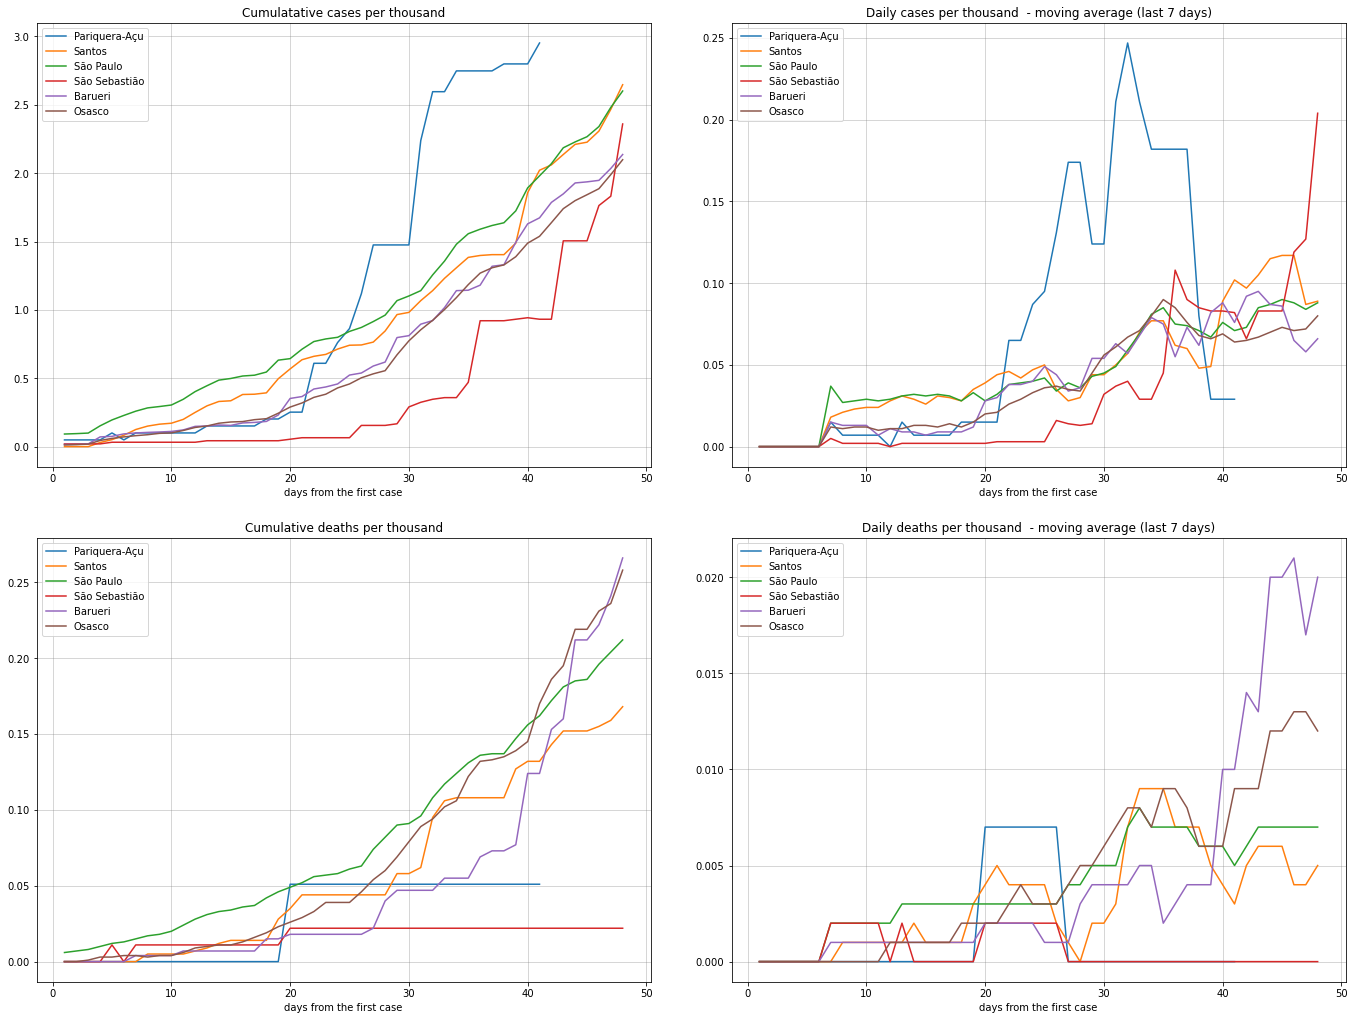

In [11]:
# Top most transmissible - SP
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(20, 20))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("Cumulatative cases per thousand")
ax1.set_xlabel("days from the first case")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("Daily cases per thousand  - moving average (last 7 days)")
ax2.set_xlabel("days from the first case")
ax2.grid(color='gray', alpha = 0.4)

ax3.set_title("Cumulative deaths per thousand")
ax3.set_xlabel("days from the first case")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("Daily deaths per thousand  - moving average (last 7 days)")
ax4.set_xlabel("days from the first case")
ax4.grid(color='gray', alpha = 0.4)

# ax5.set_title("Cumulative recoveries")
# ax5.set_xlabel("days from the first case")
# ax5.grid(color='gray', alpha = 0.4)

# ax6.set_title("Recoveries - moving average (last 7 days)")
# ax6.set_xlabel("days from the first case")
# ax6.grid(color='gray', alpha = 0.4)

for city in monitoredCities:
    dados = df[(df['city'] == city)]
    ax1.plot(dados.day, dados.cases_thousand, label = city)
    ax2.plot(dados.day, dados.avg7_case_day_thousand, label = city)
    ax3.plot(dados.day, dados.deaths_thousand, label = city)
    ax4.plot(dados.day, dados.avg7_death_day_thousand, label = city)
#     ax5.plot(df[indexes].day, df[indexes].recoveries, label = state)
#     ax6.plot(df[indexes].day, df[indexes].avg7_recoveries, label = state)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
# ax5.legend()
# ax6.legend()
fig.savefig('../analysis/saoPaulo_cities_cases_deaths.png')

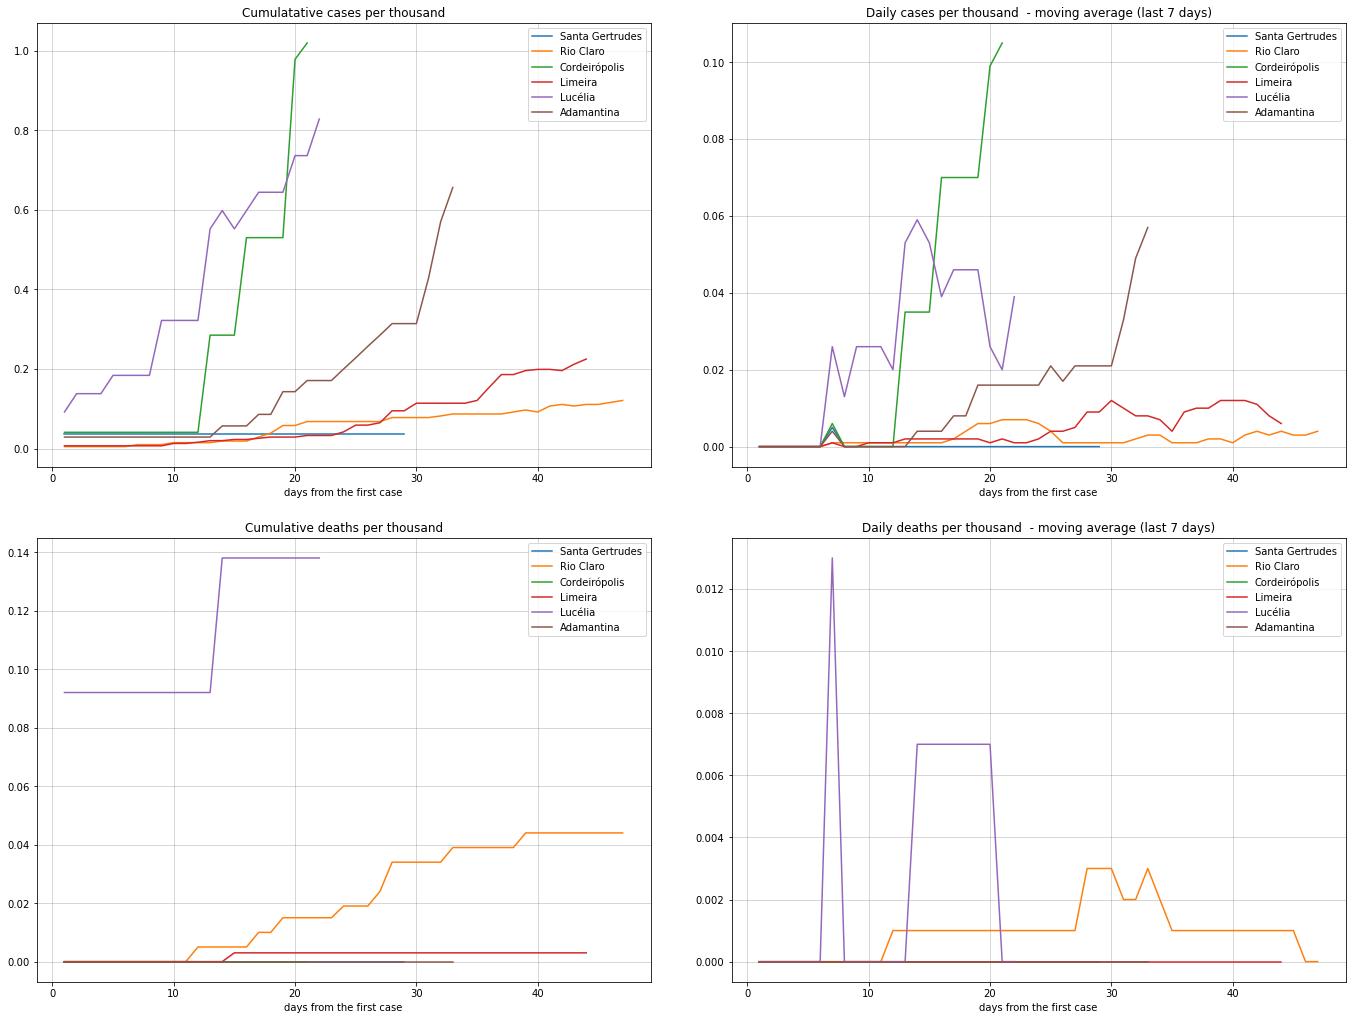

In [12]:
# Selected cities
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("Cumulatative cases per thousand")
ax1.set_xlabel("days from the first case")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("Daily cases per thousand  - moving average (last 7 days)")
ax2.set_xlabel("days from the first case")
ax2.grid(color='gray', alpha = 0.4)

ax3.set_title("Cumulative deaths per thousand")
ax3.set_xlabel("days from the first case")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("Daily deaths per thousand  - moving average (last 7 days)")
ax4.set_xlabel("days from the first case")
ax4.grid(color='gray', alpha = 0.4)

for city in addedCities:
    dados = df[(df['city'] == city)]
    ax1.plot(dados.day, dados.cases_thousand, label = city)
    ax2.plot(dados.day, dados.avg7_case_day_thousand, label = city)
    ax3.plot(dados.day, dados.deaths_thousand, label = city)
    ax4.plot(dados.day, dados.avg7_death_day_thousand, label = city)
#     ax1.plot(df[df['country'] == country].day, df[df['country'] == country].cases, label = country)
#     ax2.plot(df[df['country'] == country].day, df[df['country'] == country].deaths, label = country)
#     ax3.plot(df[df['country'] == country].day, df[df['country'] == country].avg7_cases, label = country)
#     ax4.plot(df[df['country'] == country].day, df[df['country'] == country].avg7_deaths, label = country)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
fig.savefig('../analysis/saoPaulo_selectedCities_cases_deaths.png')

### Generating the html file

In [13]:
f = open('../html/saoPaulo_analysis.html', 'w')
f1 = open('../html/templates/saoPaulo_analysis_01.html', 'r').read()
f2 = open('../html/templates/saoPaulo_analysis_02.html', 'r').read()
f3 = open('../html/templates/saoPaulo_analysis_03.html', 'r').read()

readme = f1
readme += '          <p>Indicadores relativos aos dados da pandemia Covid19 no estado de São Paulo até a data de <strong>' + today.strftime("%d/%m/%Y") + '</strong>.</p>'
readme += '          <p style="font-size:14px"><i>Estas informações são para uso próprio e não devem ser utilizadas para direcionamentos médicos e/ou políticas públicas.</i></p>'
readme += '</div></div>'
readme += '<div class="container"> '
readme += '<h3>Análise semanal</h3><br>'
readme += '<table border="1" class="dataframe " width="60%">'
readme += '  <thead>'
readme += '    <tr>'
readme += '      <th style="text-align: center;" width="25%"></th>'
readme += '      <th style="text-align: center;">'+ lastWeek.strftime("%d/%m/%Y")+ '</th>'
readme += '      <th style="text-align: center;">'+ today.strftime("%d/%m/%Y") +'</th>'
readme += '      <th style="text-align: center;"> variação </th>'
readme += '    </tr>'
readme += '  </thead>'
readme += '  <tbody>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: right;" width="25%">casos</td>'
readme += '      <td>'+str(lastWeekCases)+'</td>'
readme += '      <td>'+str(todayCases)+'</td>'
readme += '      <td>'+str(diffCases)+ ' ('+str(varCases)+'%)</td>'
readme += '    </tr>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: right;" width="25%">mortes</td>'
readme += '      <td>'+str(lastWeekDeaths)+'</td>'
readme += '      <td>'+str(todayDeaths)+'</td>'
readme += '      <td>'+str(diffDeaths)+ ' ('+str(varDeaths)+'%)</td>'
readme += '    </tr>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: center;" width="25%">cidades contaminadas</td>'
readme += '      <td>'+str(lastWeekCities)+' ('+str(lastWeekPercCities)+'%)</td>'
readme += '      <td>'+str(todayCities)+' ('+str(todayPercCities)+'%)</td>'
readme += '      <td>'+str(diffCities)+ ' ('+str(varCities)+'%)</td>'
readme += '    </tr>'
readme += '  </tbody>'
readme += '</table> </div><br>' 
readme += f2
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' cidades mais mortais do estado de São Paulo</h3>'
readme += '          <p><i>Mais: ' + str(', '.join(addedCities)).title() + '</i></p>'
readme += '          <p>O ranking é feito a partir da quantidade total de mortes por cada mil habitantes de cada cidade do estado.</p>'
readme += df_top_deaths.to_html(classes='table', decimal=',', justify='justify')
# readme += df_top_deaths.style.set_properties(**{'font-size': '12pt','border-collapse': 'collapse','border': '1px solid black'}).render()
readme += '        </div>'
readme += '        <br>'
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' cidades mais transmissíveis do estado de São Paulo</h3>'
readme += '          <p><i>Mais: ' + str(', '.join(addedCities)).title() + '</i></p>'
readme += '          <p>O ranking é feito a partir da quantidade total de casos por cada mil habitantes de cada cidade do estado.</p>'
readme += df_top_cases.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += f3

f.write(readme)
f.close()

###########################################

f = open('../html/saoPaulo_analysis_EN.html', 'w')
f1 = open('../html/templates/saoPaulo_analysis_EN_01.html', 'r').read()
f2 = open('../html/templates/saoPaulo_analysis_EN_02.html', 'r').read()
f3 = open('../html/templates/saoPaulo_analysis_EN_03.html', 'r').read()

readme = f1
readme += '<p>These indicators are related to state of San Paulo Convid19 pandemic data up to <strong>' + today.strftime("%d/%m/%Y") + '</strong>.</p>'
readme += '             <p style="font-size:14px"><i>This information is for own use only and shall NOT be used for medical and public policy guidances.</i></p>'
readme += '</div></div>'
readme += '<div class="container"> '
readme += '<h3>Weekly analysis</h3><br>'
readme += '<table border="1" class="dataframe " width="60%">'
readme += '  <thead>'
readme += '    <tr>'
readme += '      <th style="text-align: center;" width="25%"></th>'
readme += '      <th style="text-align: center;">'+ lastWeek.strftime("%d/%m/%Y")+ '</th>'
readme += '      <th style="text-align: center;">'+ today.strftime("%d/%m/%Y") +'</th>'
readme += '      <th style="text-align: center;"> variations </th>'
readme += '    </tr>'
readme += '  </thead>'
readme += '  <tbody>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: right;" width="25%">cases</td>'
readme += '      <td>'+str(lastWeekCases)+'</td>'
readme += '      <td>'+str(todayCases)+'</td>'
readme += '      <td>'+str(diffCases)+ ' ('+str(varCases)+'%)</td>'
readme += '    </tr>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: right;" width="25%">deaths</td>'
readme += '      <td>'+str(lastWeekDeaths)+'</td>'
readme += '      <td>'+str(todayDeaths)+'</td>'
readme += '      <td>'+str(diffDeaths)+ ' ('+str(varDeaths)+'%)</td>'
readme += '    </tr>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: center;" width="25%">contaminated cities</td>'
readme += '      <td>'+str(lastWeekCities)+' ('+str(lastWeekPercCities)+'%)</td>'
readme += '      <td>'+str(todayCities)+' ('+str(todayPercCities)+'%)</td>'
readme += '      <td>'+str(diffCities)+ ' ('+str(varCities)+'%)</td>'
readme += '    </tr>'
readme += '  </tbody>'
readme += '</table> </div><br>' 
readme += f2
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' deadliest cities of Sao Paulo</h3>'
readme += '          <p><i>Plus: ' + str(', '.join(addedCities)).title() + '</i></p>'
readme += '          <p>This ranking is made from the total of deaths per each thousand of population of each city of the state.</p>'
readme += df_top_deaths.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' most transmissible cities of Sao Paulo</h3>'
readme += '          <p><i>Plus: ' + str(', '.join(addedCities)).title() + '</i></p>'
readme += '          <p>This ranking is made from the total of cases per each thousand of population of each city of the state.</p>'
readme += df_top_cases.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += f3

f.write(readme)
f.close()

print('Sao Paulo\'s analysis done!')


Sao Paulo's analysis done!


In [14]:
# df[df['state']=='SP'][['date','death_day']]